# Analysis for statistics between GP and AN phases

## Necessary imports

In [74]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import matplotlib.patches as mpatches

## Useful definitions

In [81]:
def AN_map(ds_to_plt, bounds, name):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, coord=ds_to_plt.longitude)
    # cdat = ds_to_plt
    clat = ds_to_plt.latitude
    # clon = ds_to_plt.longitude

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)
    
    
    def resize_colobar(event):
        plt.draw()

        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, clat, cdat, levels=20, transform=ccrs.PlateCarree(), cmap='YlOrBr')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)    
    resize_colobar(None)
    # add box for ATL3 index
    ax.add_patch(mpatches.Rectangle(xy=[-20, -3], width=20, height=6,
                                facecolor='none', edgecolor='red',
                                transform=ccrs.PlateCarree())
                )
    plt.show()
    
    
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time, lat, lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount.
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time=-lagx).dropna(dim='time')

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x, y = xr.align(x, y)

    if lagy!=0:
        y   = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean) * (y - ymean), axis=0) / n

    #5. Compute correlation along time axis
    cor   = cov / (xstd * ystd)

    #6. Compute regression slope and intercept:
    slope     = cov / (xstd**2)
    intercept = ymean - xmean * slope  

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    from scipy.stats import t
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def cyclic_dataarray(da, coord='longitude'):
    """ Add a cyclic coordinate point to a DataArray along a specified
    named coordinate dimension.

    >>> from xray import DataArray
    >>> data = DataArray([[1, 2, 3], [4, 5, 6]],
    ...                      coords={'x': [1, 2], 'y': range(3)},
    ...                      dims=['x', 'y'])
    >>> cd = cyclic_dataarray(data, 'y')
    >>> print cd.data
    array([[1, 2, 3, 1],
           [4, 5, 6, 4]])
    """
    assert isinstance(da, xr.DataArray)

    lon_idx = da.dims.index(coord)
    cyclic_data, cyclic_coord = cutil.add_cyclic_point(da.values,
                                                 coord=da.coords[coord],
                                                 axis=lon_idx)

    # Copy and add the cyclic coordinate and data
    new_coords = dict(da.coords)
    new_coords[coord] = cyclic_coord
    new_values = cyclic_data

    new_da = xr.DataArray(new_values, dims=da.dims, coords=new_coords)

    # Copy the attributes for the re-constructed data and coords
    for att, val in da.attrs.items():
        new_da.attrs[att] = val
    for c in da.coords:
        for att in da.coords[c].attrs:
            new_da.coords[c].attrs[att] = da.coords[c].attrs[att]

    return new_da

## Data Import

In [47]:
GP = xr.load_dataset('Data/GP_results.nc')
PI = xr.load_dataset('Data/PI_results.nc')
AN = xr.load_dataset('Data/AN_Index_results.nc')

In [48]:
# shift -1.25 to 358.75
lons = np.arange(0., 360, 1.25)
GP = GP.assign_coords(longitude=lons).shift(longitude=-1)
PI = PI.assign_coords(longitude=lons).shift(longitude=-1)

In [49]:
# cftime to datetime fix on AN
dates = AN.indexes['time'].to_datetimeindex()
AN = AN.assign_coords(time=dates)

/glade/scratch/acruz/ipykernel_240101/421709906.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dates = AN.indexes['time'].to_datetimeindex()


### check values

In [33]:
GP

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 288)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    number     int64 0
    step       timedelta64[ns] 00:00:00
Data variables:
    GP         (time, latitude, longitude) float64 nan 0.0006259 ... nan nan

In [34]:
PI

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 288)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    step       timedelta64[ns] 00:00:00
    number     int64 0
Data variables:
    VMAX       (time, latitude, longitude) float64 nan 10.92 10.37 ... nan nan
    PMIN       (time, latitude, longitude) float64 nan 1.014e+03 ... nan nan
    IFL        (time, latitude, longitude) float64 0.0 1.0 1.0 ... 0.0 0.0 nan
    TO         (time, latitude, longitude) float64 nan 289.2 289.4 ... nan nan
    LNB        (time, latitude, longitude) float64 nan 833.1 842.3 ... nan nan
Attributes:
    Description:  Calculated tropical cyclone potential intensity

In [35]:
AN = AN.sel(latitude=slice(-20, 40))
AN

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 49, longitude: 288, time: 743)
Coordinates:
  * time       (time) datetime64[ns] 1958-02-01 1958-03-01 ... 2019-12-01
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    sst_mean   (month, latitude, longitude) float64 nan 22.54 22.47 ... nan nan
    sst_anom   (time, latitude, longitude) float64 nan -0.3479 ... nan nan
    index      (time) float32 nan -0.5987 -1.085 -1.48 ... 0.9143 1.174 nan
    atln_anom  (latitude, longitude) float64 nan 0.1995 0.177 ... nan nan nan
Attributes:
    Description:  Results from ATLN_Index.ipynb script based on HadiSST data.

In [66]:
GP_c = cyclic_dataarray(GP.GP)

## Sample Plots

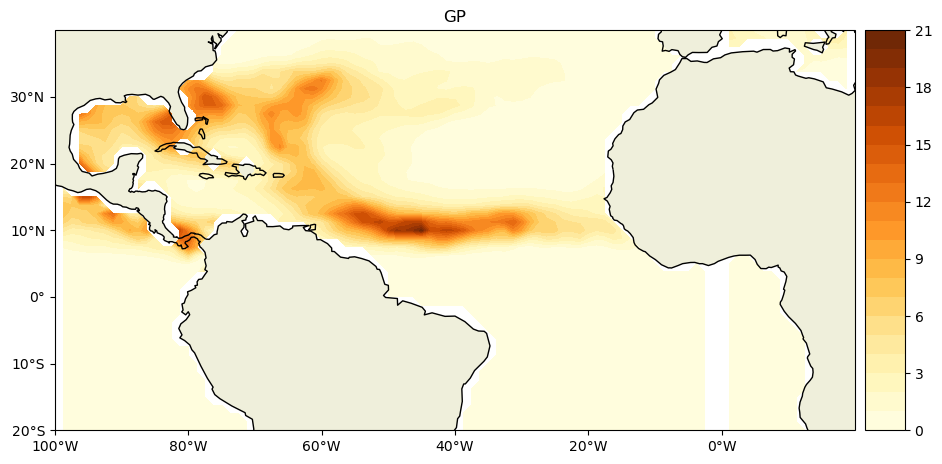

In [69]:
box = [-100, 20, -20, 40]
AN_map(GP_c[8], box, 'GP')

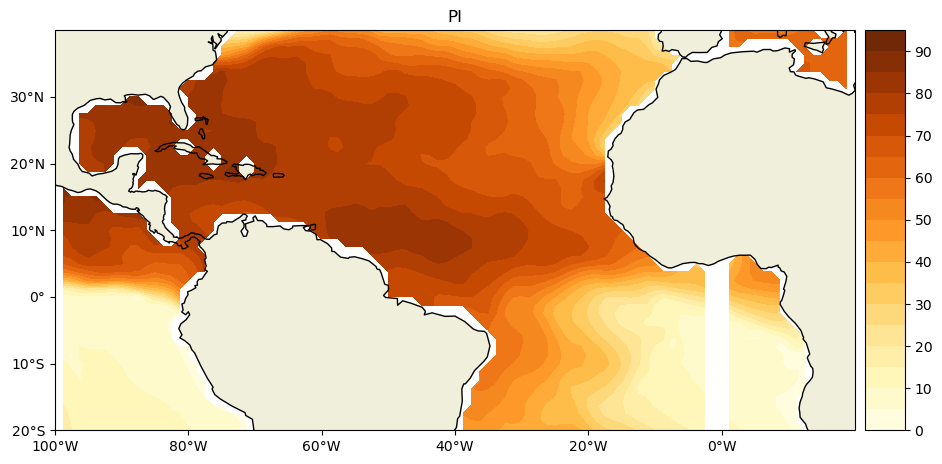

In [37]:
AN_map(PI.VMAX[8], box, 'PI')

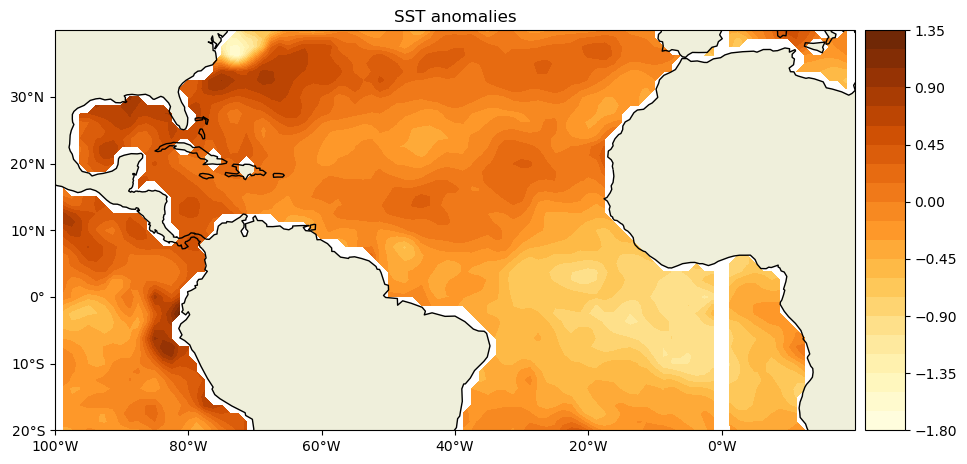

In [38]:
AN_map(AN.sst_anom[8], box, 'SST anomalies')

## Correlations

### full year GP and SST anom statistics

In [88]:
cov, cor, slope, intercept, pval, stderr = lag_linregress_3D(AN.sst_anom, GP.GP)
GP_SSTANOM = {'cov': cov, 'cor': cor, 'slope': slope, 'intercept': intercept, 'pval': pval, 'stderr':stderr}

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


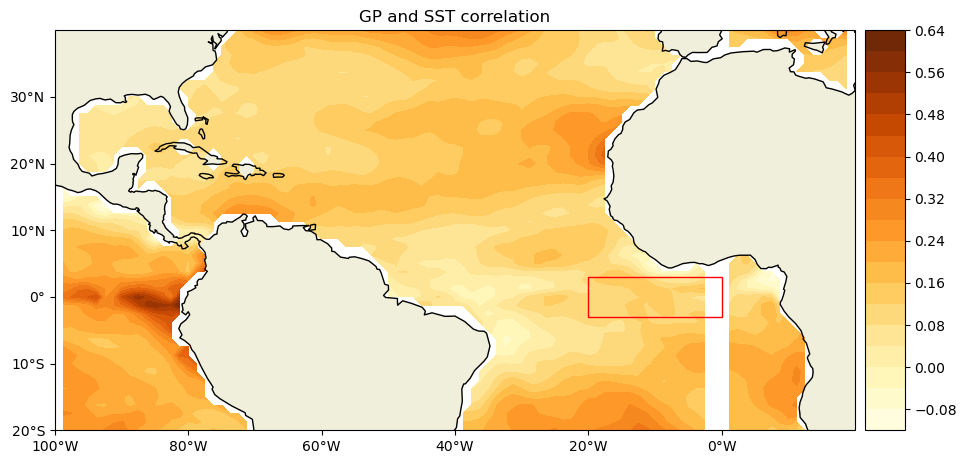

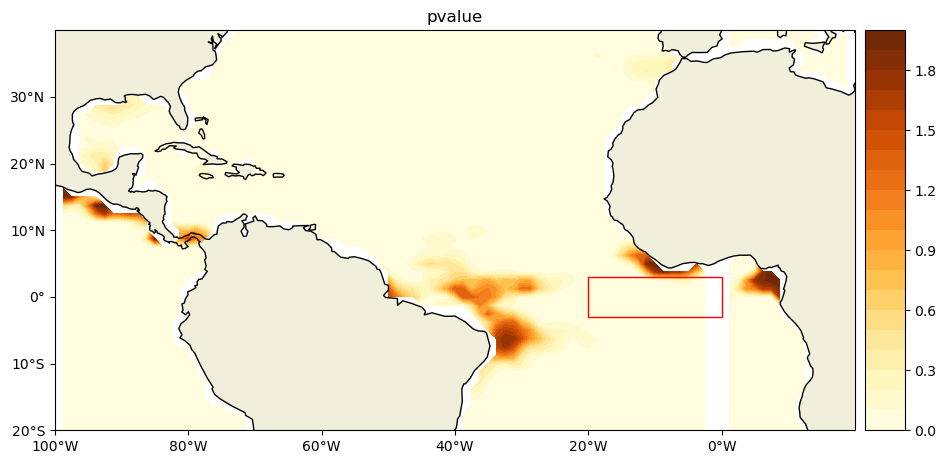

In [90]:
AN_map(GP_SSTANOM['cor'], box, 'GP and SST correlation')
AN_map(GP_SSTANOM['pval'], box, 'pvalue')

### JJA correlations

In [95]:
AN_jja = AN.where(AN["time.season"]=='JJA', drop=True)
GP_jja = GP.where(GP["time